1) Import Libraries and Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd '/content/drive/MyDrive/Project1-emotion-ai/Emotion AI Dataset'

/content/drive/MyDrive/Project1-emotion-ai/Emotion AI Dataset


In [2]:
ls

augmented.csv               FacialKeyPoints-model1.json   test.csv
data.csv                    FacialKeyPoints-model.json    training.csv
detection.json              FacialKeyPoints_weights.h5    weights_emotion.hdf5
emotion.json                FacialKeyPoints_weights.hdf5  weights_emotions.hdf5
face_detection.json         Facial_weights.hdf5           weights.h5
facial_detection.ipynb      icml_face_data.csv            weights.hdf5
FacialEmotion-model.json    models.config                 weights_keypoint.hdf5
FacialEmotion_weights.hdf5  server.log


In [3]:
# Import the necessary packages

import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob


In [4]:
# loading facial key points data
keyfacial_df = pd.read_csv('data.csv')

In [5]:
keyfacial_df.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

In [6]:
keyfacial_df.head(1)

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274           30.227008   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.421678                59.582075                39.647423   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.130346                39.969997                 36.356571   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 37.389402  ...   57.066803            61.195308   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            79.970165             28.614496             77.388992   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               43.312602               72.935459                  43.130707   

   mouth_center_bottom_lip_y  \
0                  84.485774   

                                               Image  
0  238 236 237 238 240 240 239 241 241 243 240 23...  

[1 rows x 31 columns]

In [7]:
keyfacial_df['Image'][0]

'238 236 237 238 240 240 239 241 241 243 240 239 231 212 190 173 148 122 104 92 79 73 74 73 73 74 81 74 60 64 75 86 93 102 100 105 109 114 121 127 132 134 137 137 140 139 138 137 137 140 141 143 144 147 148 149 147 147 148 145 147 144 146 147 147 143 134 130 130 128 116 104 98 90 82 78 85 88 86 80 77 87 108 111 115 128 133 188 242 252 250 248 251 250 250 250 235 238 236 238 238 237 238 242 241 239 237 233 215 195 187 156 119 103 93 78 68 73 75 75 72 75 70 61 66 77 91 96 106 108 113 120 125 131 134 138 135 138 139 145 144 144 142 140 141 141 148 147 150 149 152 151 149 150 147 148 144 148 144 146 146 143 139 128 132 135 128 112 104 97 87 78 79 83 85 83 75 75 89 109 111 117 117 130 194 243 251 249 250 249 250 251 237 236 237 238 237 238 241 238 238 238 241 221 195 187 163 124 106 95 81 68 70 73 73 72 73 69 65 74 82 94 103 110 111 119 127 135 140 139 144 144 145 143 143 143 146 144 144 147 146 148 147 150 146 147 150 150 149 147 147 144 147 144 149 146 144 144 144 140 131 133 133 125 110 

In [8]:
keyfacial_df.describe()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
count        2140.000000        2140.000000         2140.000000   
mean           66.221549          36.842274           29.640269   
std             2.087683           2.294027            2.051575   
min            47.835757          23.832996           18.922611   
25%            65.046300          35.468842           28.472224   
50%            66.129065          36.913319           29.655440   
75%            67.332093          38.286438           30.858673   
max            78.013082          46.132421           42.495172   

       right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
count         2140.000000              2140.000000              2140.000000   
mean            37.063815                59.272128                37.856014   
std              2.234334                 2.005631                 2.034500   
min             24.773072                41.779381                27.190098   
25%             35.818377                58.113054                36.607950   
50%             37.048085                59.327154                37.845220   
75%             38.333884                60.521492                39.195431   
max             45.980981                69.023030                47.190316   

       left_eye_outer_corner_x  left_eye_outer_corner_y  \
count              2140.000000              2140.000000   
mean                 73.412473                37.640110   
std                   2.701639                 2.684162   
min                  52.947144                26.250023   
25%                  71.741978                36.102409   
50%                  73.240045                37.624207   
75%                  74.978684                39.308331   
max                  87.032252                49.653825   

       right_eye_inner_corner_x  right_eye_inner_corner_y  ...   nose_tip_x  \
count               2140.000000               2140.000000  ...  2140.000000   
mean                  36.603107                 37.920852  ...    47.952141   
std                    1.822784                  2.009505  ...     3.276053   
min                   24.112624                 26.250023  ...    24.472590   
25%                   35.495730                 36.766783  ...    46.495330   
50%                   36.620735                 37.920336  ...    47.900511   
75%                   37.665280                 39.143921  ...    49.260657   
max                   47.293746                 44.887301  ...    65.279654   

        nose_tip_y  mouth_left_corner_x  mouth_left_corner_y  \
count  2140.000000          2140.000000          2140.000000   
mean     57.253926            63.419076            75.887660   
std       4.528635             3.650131             4.438565   
min      41.558400            43.869480            57.023258   
25%      54.466000            61.341291            72.874263   
50%      57.638582            63.199057            75.682465   
75%      60.303524            65.302398            78.774969   
max      75.992731            84.767123            94.673637   

       mouth_right_corner_x  mouth_right_corner_y  mouth_center_top_lip_x  \
count           2140.000000           2140.000000             2140.000000   
mean              32.967365             76.134065               48.081325   
std                3.595103              4.259514                2.723274   
min                9.778137             56.690208               32.260312   
25%               30.879288             73.280038               46.580004   
50%               33.034022             75.941985               47.939031   
75%               35.063575             78.884031               49.290000   
max               50.973348             93.443176               61.804506   

       mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
count             2140.000000                2140.000000   
mean                72.681125                  48.149654

In [9]:
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [10]:
print(keyfacial_df.Image)
print('\n')
print("\nThe shape of Image is: ",keyfacial_df.Image.shape)

0       238 236 237 238 240 240 239 241 241 243 240 23...
1       219 215 204 196 204 211 212 200 180 168 178 19...
2       144 142 159 180 188 188 184 180 167 132 84 59 ...
3       193 192 193 194 194 194 193 192 168 111 50 12 ...
4       147 148 160 196 215 214 216 217 219 220 206 18...
                              ...                        
2135    191 191 191 190 189 185 184 120 54 34 19 24 31...
2136    19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137    31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138    7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...
2139    68 19 19 23 19 26 23 16 8 15 9 9 17 16 15 27 2...
Name: Image, Length: 2140, dtype: object



The shape of Image is:  (2140,)


From above cell we can say that, our image is in 1D array format

In [11]:
# Check if null values exist in the dataframe
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [12]:
# Since values for the image are given as space separated string, separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96, 96)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))


#  "lambda x: np.fromstring(x, dtype = int, sep = ' ')" 
#  This is a lambda function that takes an input 'x' (which represents an image in string format) and 
#  converts it to a numpy array of integers using the 'np.fromstring()' function. 
#  This function takes three arguments: the input string ('x'), the data type of the resulting numpy array (in this case, 'int'), 
#  and the separator used in the input string to separate the values of the array (in this case, ' ').
#  This line od code replacing the original string representation of each image with its integer array representation
#  reshape(96 x 96): reshaping integer array in to 96x96 matrix

In [13]:
print(keyfacial_df.Image)

0       [[238, 236, 237, 238, 240, 240, 239, 241, 241,...
1       [[219, 215, 204, 196, 204, 211, 212, 200, 180,...
2       [[144, 142, 159, 180, 188, 188, 184, 180, 167,...
3       [[193, 192, 193, 194, 194, 194, 193, 192, 168,...
4       [[147, 148, 160, 196, 215, 214, 216, 217, 219,...
                              ...                        
2135    [[191, 191, 191, 190, 189, 185, 184, 120, 54, ...
2136    [[19, 19, 19, 18, 13, 7, 3, 4, 3, 1, 3, 9, 11,...
2137    [[31, 40, 47, 31, 54, 58, 63, 100, 86, 80, 82,...
2138    [[7, 1, 5, 1, 3, 20, 12, 0, 5, 8, 6, 18, 13, 9...
2139    [[68, 19, 19, 23, 19, 26, 23, 16, 8, 15, 9, 9,...
Name: Image, Length: 2140, dtype: object


In [14]:
print(keyfacial_df['Image'][0].shape)
print(keyfacial_df['Image'].shape)

(96, 96)
(2140,)


2)PERFORM IMAGE VISUALIZATION

374


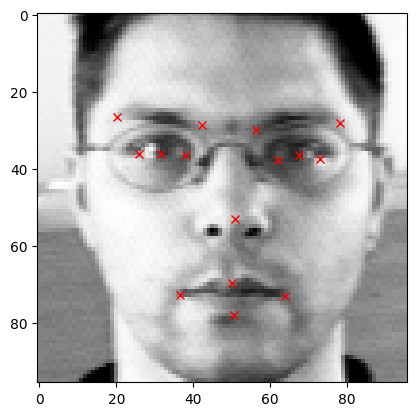

In [15]:
# Plot a random image from the dataset along with facial keypoints. 
# Image data is obtained from df['Image'] and plotted using plt.imshow
# 15 x and y coordinates for the corresponding image 
# since x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
# we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to.
i = np.random.randint(1, len(keyfacial_df))
print(i)
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


70


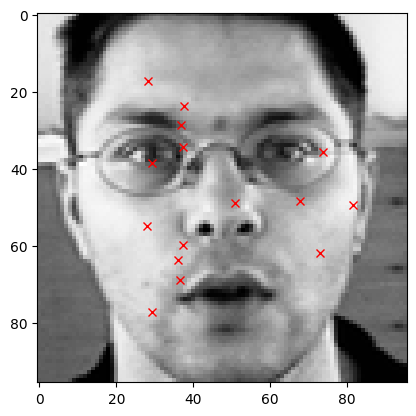

In [16]:
#same code as above just cahnged the x and y cordinate
i = np.random.randint(1, len(keyfacial_df))
print(i)
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[i][j], keyfacial_df.loc[i][j-1], 'rx')

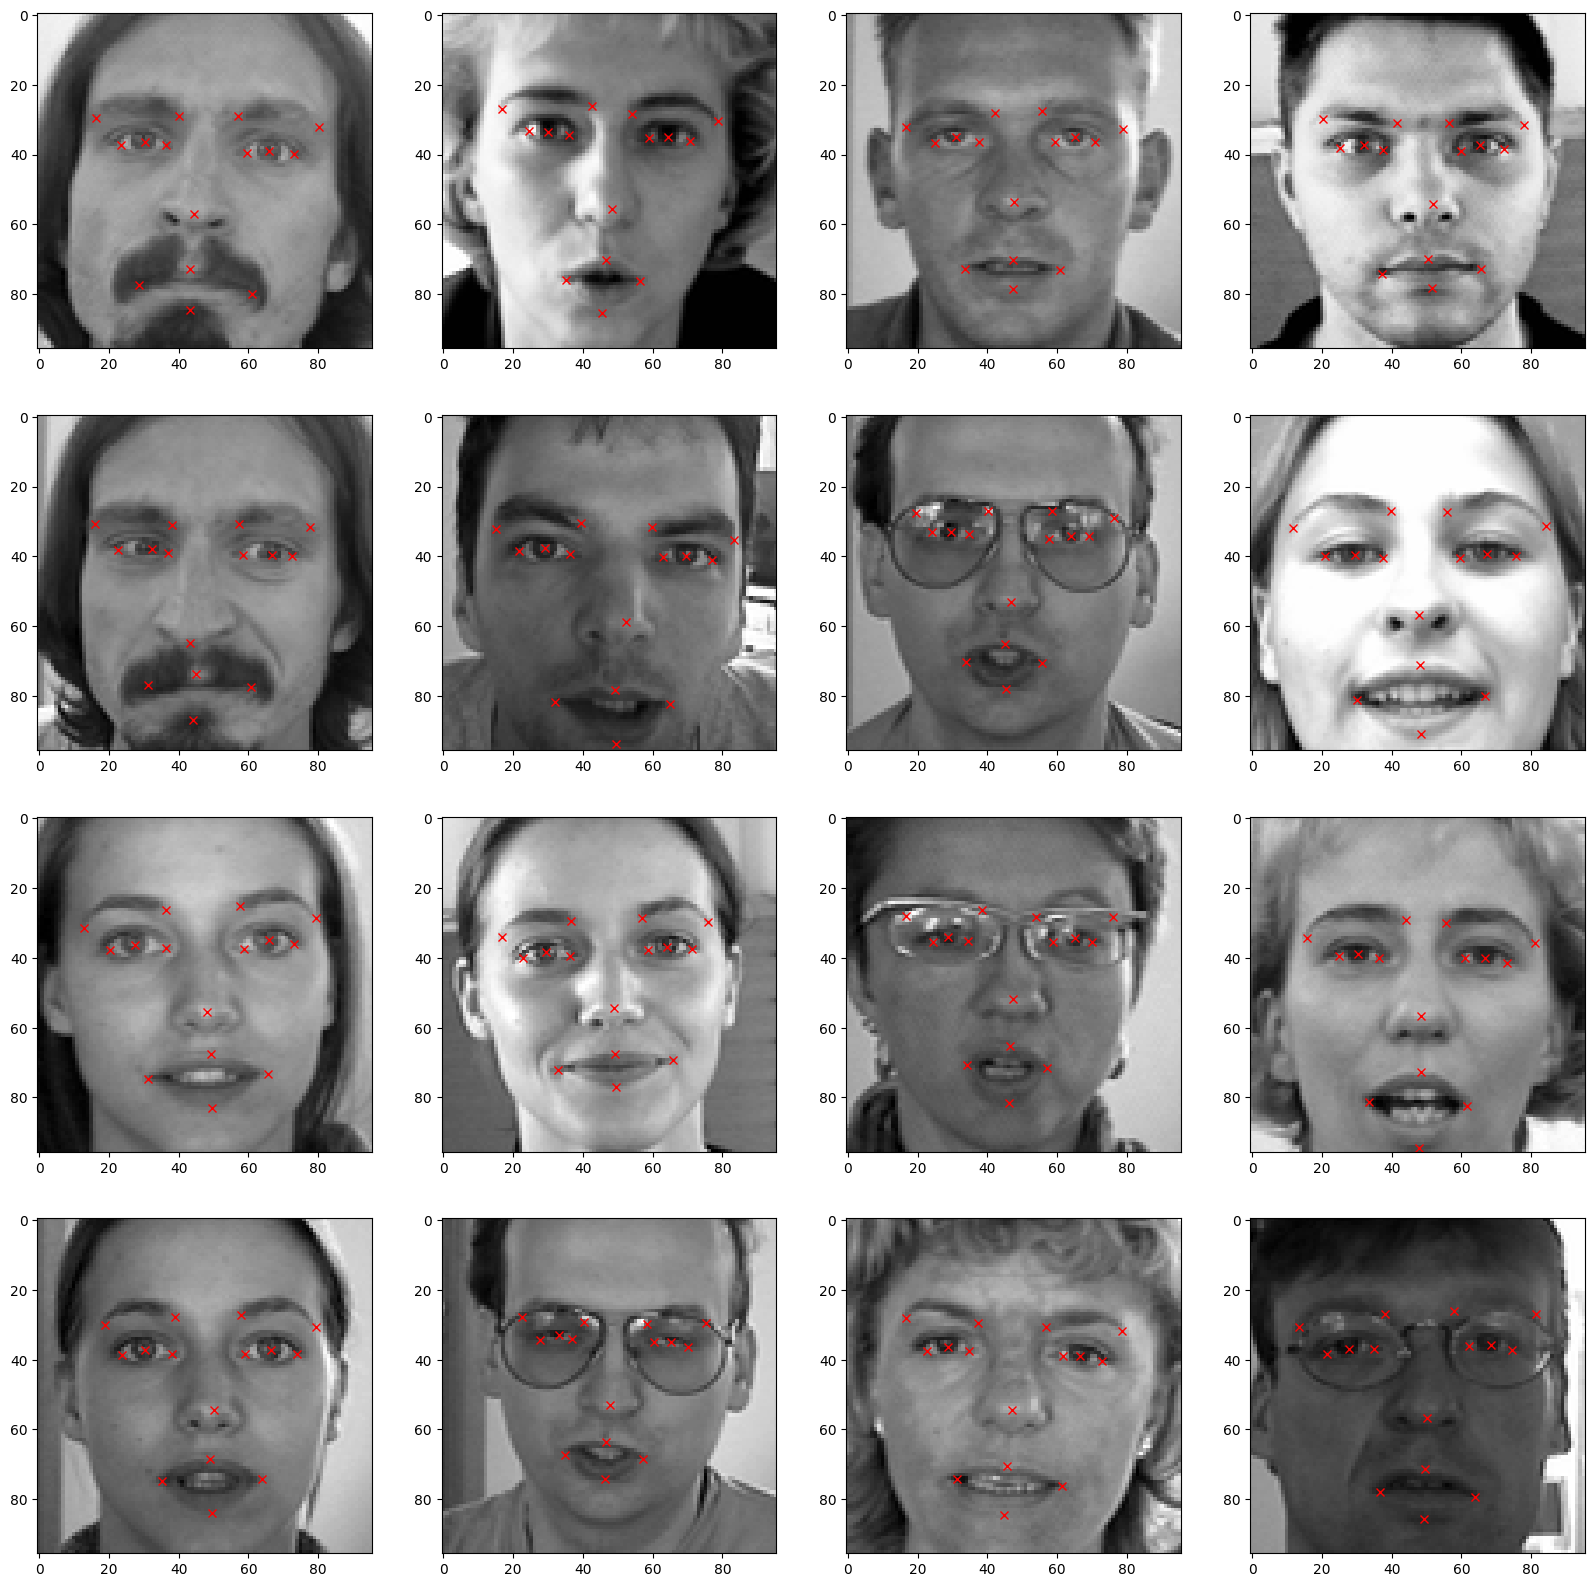

In [17]:
# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)    
    image = plt.imshow(keyfacial_df['Image'][i],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

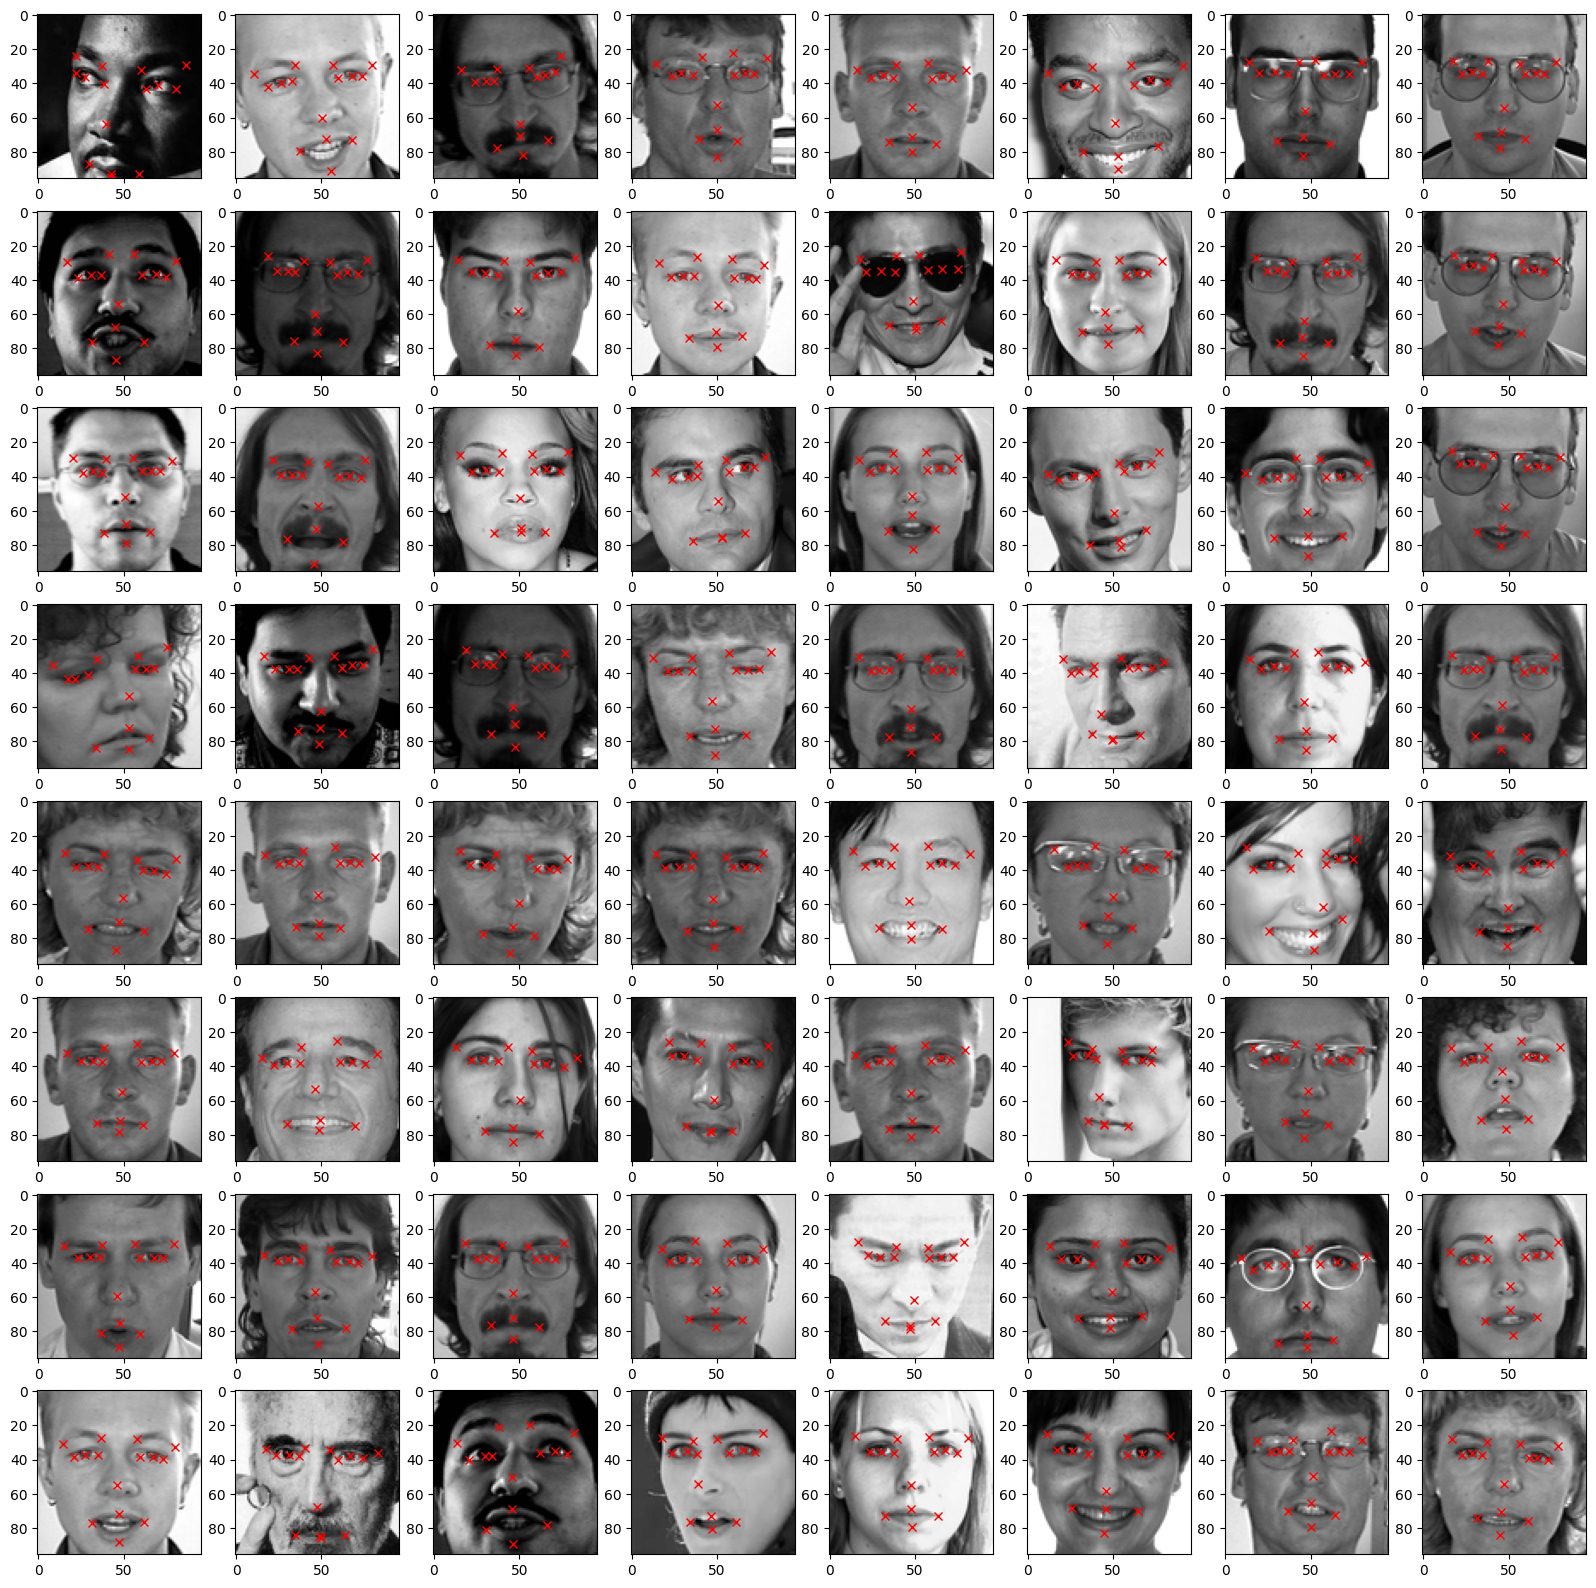

In [18]:
import random
# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(64):
    k = random.randint(1, len(keyfacial_df))
    ax = fig.add_subplot(8, 8, i + 1)    
    image = plt.imshow(keyfacial_df['Image'][k],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')
    

3) IMAGE AUGMENTATION

In [19]:
# Create a new copy of the dataframe
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [20]:
keyfacial_df_copy.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

In [21]:
# Obtain the columns in the dataframe

columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [22]:
keyfacial_df_copy['Image']

0       [[238, 236, 237, 238, 240, 240, 239, 241, 241,...
1       [[219, 215, 204, 196, 204, 211, 212, 200, 180,...
2       [[144, 142, 159, 180, 188, 188, 184, 180, 167,...
3       [[193, 192, 193, 194, 194, 194, 193, 192, 168,...
4       [[147, 148, 160, 196, 215, 214, 216, 217, 219,...
                              ...                        
2135    [[191, 191, 191, 190, 189, 185, 184, 120, 54, ...
2136    [[19, 19, 19, 18, 13, 7, 3, 4, 3, 1, 3, 9, 11,...
2137    [[31, 40, 47, 31, 54, 58, 63, 100, 86, 80, 82,...
2138    [[7, 1, 5, 1, 3, 20, 12, 0, 5, 8, 6, 18, 13, 9...
2139    [[68, 19, 19, 23, 19, 26, 23, 16, 8, 15, 9, 9,...
Name: Image, Length: 2140, dtype: object

In [23]:
# Horizontal Flip - flip the images along y axis
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

In [24]:
# since we are flipping horizontally, y coordinate values would be the same
# Only x coordiante values would change, all we have to do is to subtract our initial x-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 0:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

In [25]:
keyfacial_df_copy['Image']

0       [[250, 250, 250, 251, 248, 250, 252, 242, 188,...
1       [[84, 88, 92, 93, 96, 97, 100, 100, 93, 98, 10...
2       [[207, 207, 208, 207, 207, 208, 213, 205, 175,...
3       [[202, 199, 199, 197, 196, 196, 195, 195, 193,...
4       [[213, 192, 151, 119, 111, 94, 86, 68, 75, 80,...
                              ...                        
2135    [[21, 21, 18, 19, 33, 34, 48, 60, 61, 70, 89, ...
2136    [[9, 7, 3, 5, 10, 15, 17, 19, 23, 23, 19, 11, ...
2137    [[197, 198, 198, 197, 195, 191, 184, 155, 71, ...
2138    [[38, 20, 9, 9, 40, 20, 34, 41, 27, 30, 18, 13...
2139    [[3, 8, 3, 2, 21, 22, 19, 4, 6, 3, 2, 2, 5, 11...
Name: Image, Length: 2140, dtype: object

In [26]:
keyfacial_df_copy1 = copy.copy(keyfacial_df)

In [27]:
#Image Flip
keyfacial_df_copy1['Image'] = keyfacial_df_copy1['Image'].apply(lambda x: np.flip(x, axis = 0))

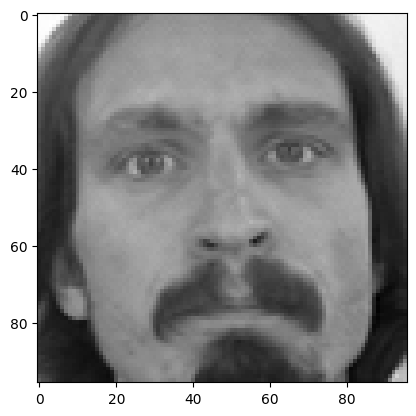

In [28]:
plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')

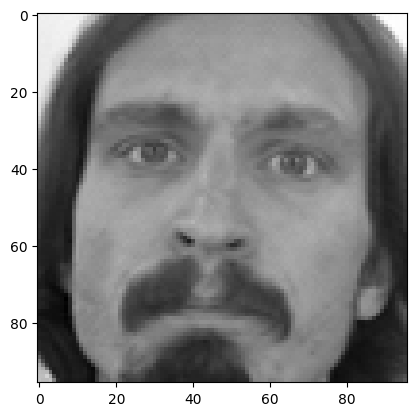

In [29]:
plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')

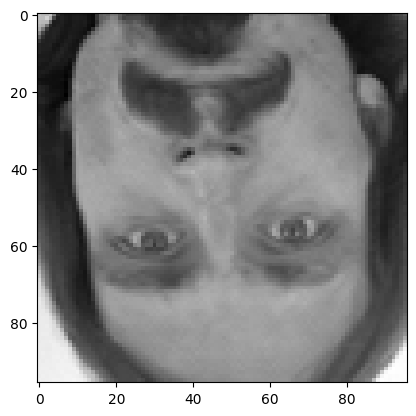

In [30]:
plt.imshow(keyfacial_df_copy1['Image'][0], cmap='gray')

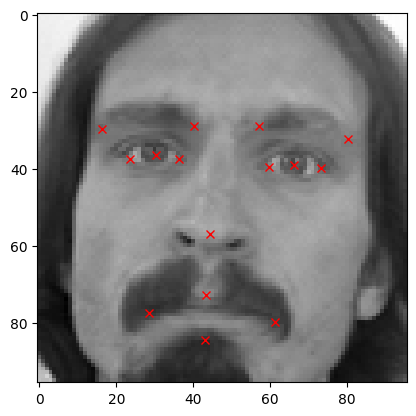

In [31]:
# Show the Original image
plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')

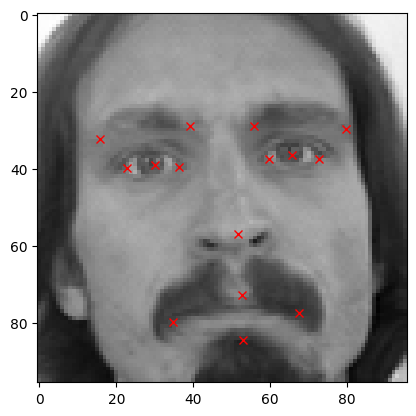

In [32]:
# Show the Horizontally flipped image
plt.imshow(keyfacial_df_copy['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [33]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))

In [34]:
augmented_df.shape

(4280, 31)

In [35]:
augmented_df

array([[66.0335639098, 39.0022736842, 30.2270075188, ..., 43.1307067669,
        84.4857744361, array([[238, 236, 237, ..., 250, 250, 250],
                              [235, 238, 236, ..., 249, 250, 251],
                              [237, 236, 237, ..., 251, 251, 250],
                              ...,
                              [186, 183, 181, ...,  52,  57,  60],
                              [189, 188, 207, ...,  61,  69,  78],
                              [191, 184, 184, ...,  70,  75,  90]])],
       [64.3329361702, 34.9700765957, 29.9492765957, ..., 45.4679148936,
        85.48017021279999, array([[219, 215, 204, ...,  92,  88,  84],
                                  [222, 219, 220, ...,  92,  88,  86],
                                  [231, 224, 212, ...,  77,  80,  84],
                                  ...,
                                  [  1,   1,   1, ...,   1,   1,   1],
                                  [  1,   1,   1, ...,   1,   1,   1],
                    

In [36]:
keyfacial_df_copy2 = copy.copy(keyfacial_df)

In [37]:
keyfacial_df_copy2['Image']=keyfacial_df_copy2['Image'].apply(lambda x: np.clip(random.uniform(1.5,2.0)*x,0.0,255.0))
#the lambda function is applied to each element in the "Image" column, 
#where "random.uniform(1.5, 2)" generates a random number between 1.5 and 2 
# that will be multiplied by each pixel value in the image. 
# This multiplication results in the image having increased contrast.


#The NumPy "clip" function is then applied to ensure that the pixel values in the image are between 0 and 255. 
#This step is necessary because pixel values outside this range may not be displayed correctly and may lead to errors in further image processing.

In [38]:
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy2))
augmented_df.shape

(6420, 31)

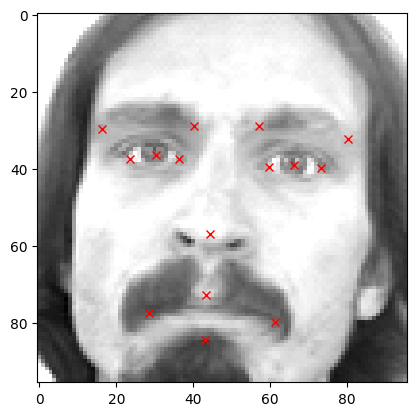

In [39]:
# Show Image with increased brightness

plt.imshow(keyfacial_df_copy2['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy2.loc[0][j-1], keyfacial_df_copy2.loc[0][j], 'rx')

In [40]:
augmented_df.shape

(6420, 31)

4)PERFORM DATA NORMALIZATION AND TRAINING DATA PREPARATION

In [41]:
augmented_df[0]

array([66.0335639098, 39.0022736842, 30.2270075188, 36.4216781955,
       59.582075188000005, 39.6474225564, 73.1303458647, 39.9699969925,
       36.3565714286, 37.3894015038, 23.4528721805, 37.3894015038,
       56.9532631579, 29.0336481203, 80.2271278195, 32.2281383459,
       40.2276090226, 29.0023218045, 16.3563789474, 29.6474706767,
       44.4205714286, 57.0668030075, 61.1953082707, 79.9701654135,
       28.6144962406, 77.38899248119999, 43.3126015038, 72.9354586466,
       43.1307067669, 84.4857744361,
       array([[238, 236, 237, ..., 250, 250, 250],
              [235, 238, 236, ..., 249, 250, 251],
              [237, 236, 237, ..., 251, 251, 250],
              ...,
              [186, 183, 181, ...,  52,  57,  60],
              [189, 188, 207, ...,  61,  69,  78],
              [191, 184, 184, ...,  70,  75,  90]])], dtype=object)

In [42]:
#Normalize Image column

img = augmented_df[:,30]
print(img[0])
print('\n')
# Normalize the images
img = img/255.
print(img[0])

[[238 236 237 ... 250 250 250]
 [235 238 236 ... 249 250 251]
 [237 236 237 ... 251 251 250]
 ...
 [186 183 181 ...  52  57  60]
 [189 188 207 ...  61  69  78]
 [191 184 184 ...  70  75  90]]


[[0.93333333 0.9254902  0.92941176 ... 0.98039216 0.98039216 0.98039216]
 [0.92156863 0.93333333 0.9254902  ... 0.97647059 0.98039216 0.98431373]
 [0.92941176 0.9254902  0.92941176 ... 0.98431373 0.98431373 0.98039216]
 ...
 [0.72941176 0.71764706 0.70980392 ... 0.20392157 0.22352941 0.23529412]
 [0.74117647 0.7372549  0.81176471 ... 0.23921569 0.27058824 0.30588235]
 [0.74901961 0.72156863 0.72156863 ... 0.2745098  0.29411765 0.35294118]]


In [43]:
len(img)

6420

In [44]:
# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

In [45]:
X.shape

(6420, 96, 96, 1)

In [46]:
# Iterate through the img list and add image values to the empty array after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [47]:
X[0]

array([[[0.93333334],
        [0.9254902 ],
        [0.92941177],
        ...,
        [0.98039216],
        [0.98039216],
        [0.98039216]],

       [[0.92156863],
        [0.93333334],
        [0.9254902 ],
        ...,
        [0.9764706 ],
        [0.98039216],
        [0.9843137 ]],

       [[0.92941177],
        [0.9254902 ],
        [0.92941177],
        ...,
        [0.9843137 ],
        [0.9843137 ],
        [0.98039216]],

       ...,

       [[0.7294118 ],
        [0.7176471 ],
        [0.70980394],
        ...,
        [0.20392157],
        [0.22352941],
        [0.23529412]],

       [[0.7411765 ],
        [0.7372549 ],
        [0.8117647 ],
        ...,
        [0.23921569],
        [0.27058825],
        [0.30588236]],

       [[0.7490196 ],
        [0.72156864],
        [0.72156864],
        ...,
        [0.27450982],
        [0.29411766],
        [0.3529412 ]]], dtype=float32)

In [48]:
# Obtain the value of x & y coordinates which are to used as target.
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
# Converts a given NumPy array 'y' into a new NumPy array of data type float32.
# "np.asarray(y)" : This code creates a new NumPy array from the input 'y'. If 'y' is already a NumPy array, it simply returns the same array. 
# If 'y' is a list or a tuple, it converts it into a NumPy array. 
# This step is useful to ensure that the input 'y' is a NumPy array before performing any array operations on it.

y.shape

(6420, 30)

In [49]:
y[0]

array([66.03356 , 39.002274, 30.227007, 36.421677, 59.582077, 39.647423,
       73.13035 , 39.969997, 36.35657 , 37.3894  , 23.452871, 37.3894  ,
       56.953262, 29.033648, 80.22713 , 32.228138, 40.227608, 29.002321,
       16.356379, 29.64747 , 44.42057 , 57.066803, 61.19531 , 79.97017 ,
       28.614496, 77.38899 , 43.312603, 72.935455, 43.130707, 84.48577 ],
      dtype=float32)

In [50]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [51]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5136, 96, 96, 1)
(1284, 96, 96, 1)
(5136, 30)
(1284, 30)


5) BUILD DEEP RESIDUAL NEURAL NETWORK KEY FACIAL POINTS DETECTION MODEL 

In [52]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [53]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model_1_facialKeyPoints = tf.keras.Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1[0][0]']                  
                                                                                              

6) COMPILE AND TRAIN KEY FACIAL POINTS DETECTION DEEP LEARNING MODEL

In [54]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam , metrics = ['accuracy'])
# Check this out for more information on Adam optimizer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

# # save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only = True)

history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size = 32, epochs = 200, validation_split = 0.05, callbacks=[checkpointer])

Epoch 1/200
153/153 [==============================] - ETA: 0s - loss: 339.4599 - accuracy: 0.5595
Epoch 1: val_loss improved from inf to 906.71558, saving model to FacialKeyPoints_weights.hdf5
153/153 [==============================] - 39s 65ms/step - loss: 339.4599 - accuracy: 0.5595 - val_loss: 906.7156 - val_accuracy: 0.7198
Epoch 2/200
152/153 [============================>.] - ETA: 0s - loss: 102.6301 - accuracy: 0.6040
Epoch 2: val_loss improved from 906.71558 to 304.30801, saving model to FacialKeyPoints_weights.hdf5
153/153 [==============================] - 5s 29ms/step - loss: 102.6749 - accuracy: 0.6038 - val_loss: 304.3080 - val_accuracy: 0.7198
Epoch 3/200
152/153 [============================>.] - ETA: 0s - loss: 68.8153 - accuracy: 0.5831
Epoch 3: val_loss improved from 304.30801 to 203.53578, saving model to FacialKeyPoints_weights.hdf5
153/153 [==============================] - 5s 30ms/step - loss: 68.7534 - accuracy: 0.5833 - val_loss: 203.5358 - val_accuracy: 0.7198

In [55]:
# save the model architecture to json file for future use

model_json = model_1_facialKeyPoints.to_json()
with open("FacialKeyPoints-model.json","w") as json_file:
  json_file.write(model_json)

In [56]:
with open('FacialKeyPoints-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights('FacialKeyPoints_weights.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer= adam , metrics = ['accuracy'])

In [57]:
# Evaluate the model

result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

41/41 [==============================] - 1s 15ms/step - loss: 55.1433 - accuracy: 0.7889
Accuracy : 0.7889407873153687


In [58]:
# Get the model keys 
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

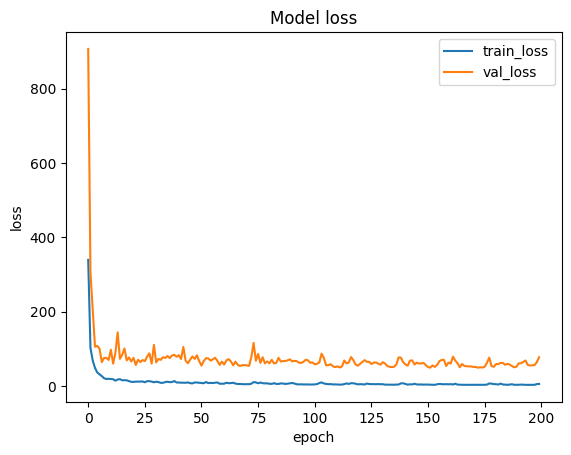

In [59]:
# Plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

7) IMPORT & EXPLORE DATASET FOR FACIAL EXPRESSION DETECTION

In [60]:
# read the csv files for the facial expression data
facialexpression_df = pd.read_csv('icml_face_data.csv')

In [61]:
facialexpression_df

emotion                                             pixels
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0  151 150 147 155 148 133 111 140 170 174 182 15...
2            2  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3            2  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4            3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
...        ...                                                ...
24563        3  0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564        0  181 177 176 156 178 144 136 132 122 107 131 16...
24565        3  178 174 172 173 181 188 191 194 196 199 200 20...
24566        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
24567        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...

[24568 rows x 2 columns]

In [62]:
facialexpression_df[' pixels'][0] # String format

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [63]:
# function to convert pixel values in string format to array format

def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')



# Resize images from (48, 48) to (96, 96)
def resize(x):
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)  

# The resize function takes an input array x and resizes it from (48, 48) dimensions to (96, 96) dimensions using the cv2.resize function from the OpenCV library. 
# The dsize parameter specifies the desired size of the output image, which in this case is (96, 96). 
# The interpolation parameter is set to cv2.INTER_CUBIC, indicating that cubic interpolation should be used to adjust the pixel values during the resizing process. 
# The function returns the resized image.  

In [64]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))

In [65]:
facialexpression_df[' pixels'][0]

array([[[ 70.],
        [ 80.],
        [ 82.],
        ...,
        [ 52.],
        [ 43.],
        [ 41.]],

       [[ 65.],
        [ 61.],
        [ 58.],
        ...,
        [ 56.],
        [ 52.],
        [ 44.]],

       [[ 50.],
        [ 43.],
        [ 54.],
        ...,
        [ 49.],
        [ 56.],
        [ 47.]],

       ...,

       [[ 91.],
        [ 65.],
        [ 42.],
        ...,
        [ 72.],
        [ 56.],
        [ 43.]],

       [[ 77.],
        [ 82.],
        [ 79.],
        ...,
        [105.],
        [ 70.],
        [ 46.]],

       [[ 77.],
        [ 72.],
        [ 84.],
        ...,
        [106.],
        [109.],
        [ 82.]]], dtype=float32)

In [66]:
facialexpression_df[' pixels'][0].shape

(48, 48, 1)

In [67]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))

In [68]:
facialexpression_df[' pixels'][0]

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [69]:
facialexpression_df[' pixels'][0].shape

(96, 96)

In [70]:
facialexpression_df.head()

emotion                                             pixels
0        0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        2  [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        2  [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        3  [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...

In [71]:
# check the shape of data_frame
facialexpression_df.shape

(24568, 2)

In [72]:
# check for the presence of null values in the data frame
facialexpression_df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

In [73]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

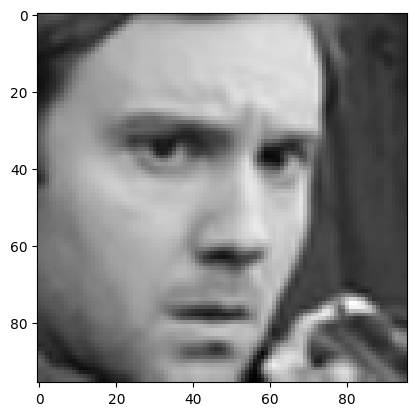

In [74]:
plt.imshow(facialexpression_df[' pixels'][0], cmap = 'gray')

8)VISUALIZE IMAGES AND PLOT LABELS

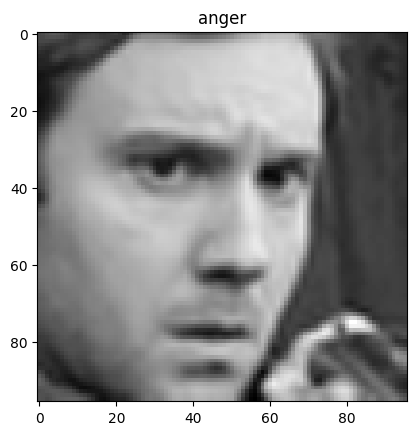

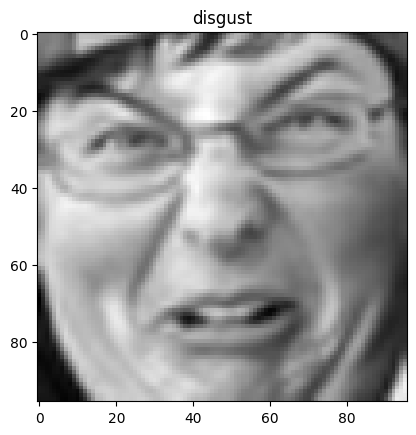

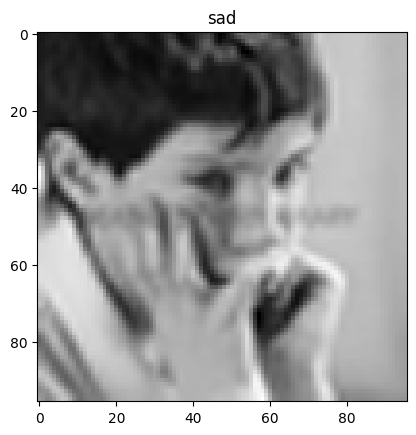

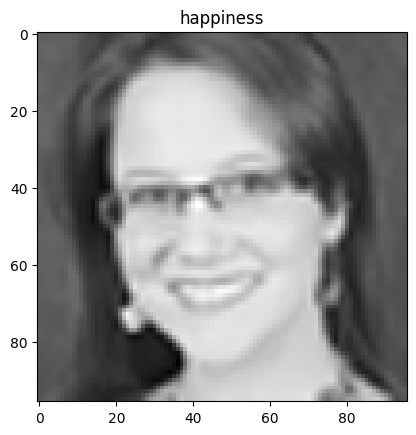

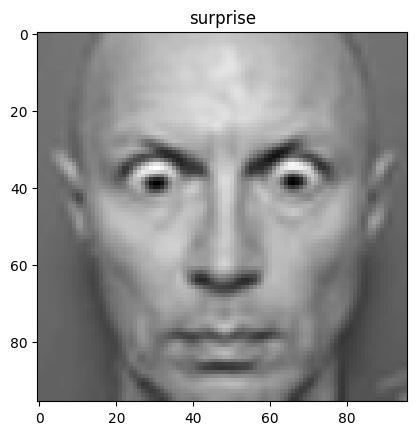

In [75]:
emotions = [0, 1, 2, 3, 4]

for i in emotions:
  data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
  img = data[' pixels'].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

In [76]:
facialexpression_df.emotion.value_counts().index

Int64Index([3, 2, 0, 4, 1], dtype='int64')

In [77]:
facialexpression_df.emotion.value_counts()

3    8989
2    6077
0    4953
4    4002
1     547
Name: emotion, dtype: int64

<Axes: ylabel='emotion'>

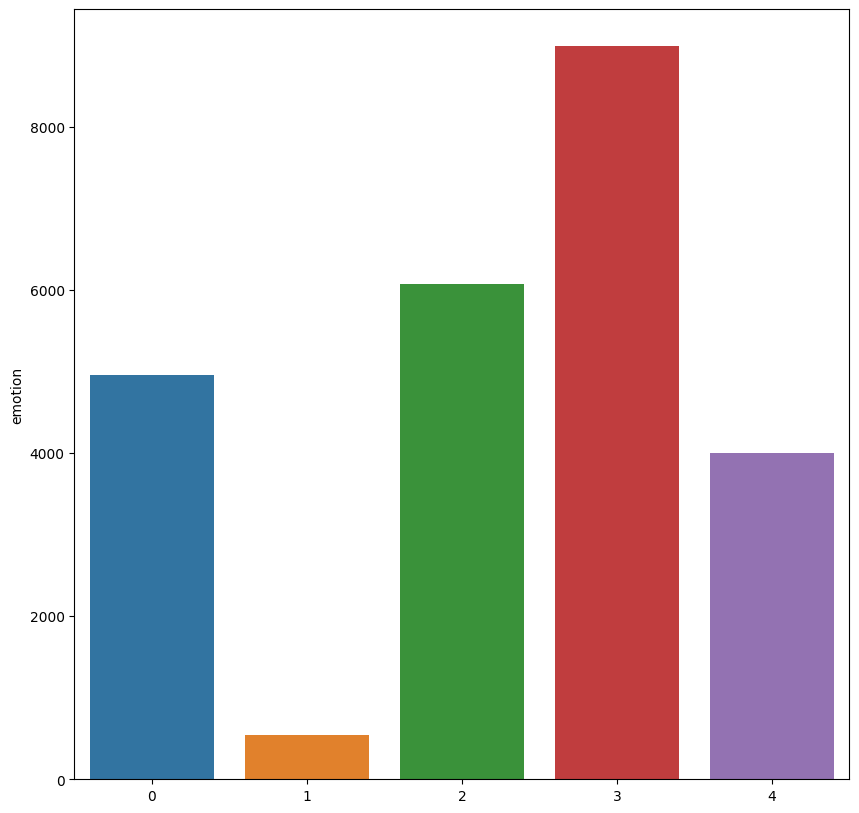

In [78]:
plt.figure(figsize = (10,10))
sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())

9) PERFORM DATA PREPARATION AND IMAGE AUGMENTATION

In [79]:
# split the dataframe in to features and labels
from keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion']) # "to_categorical" - method in python is used to convert a class vector (integers) to a binary class matrix.
# NOTE : The categorical cross-entropy loss function is designed to be used with binary class matrices. 


In [80]:
X[0]

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [81]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [82]:
X.shape

(24568,)

In [83]:
y.shape

(24568, 5)

In [84]:

X = np.stack(X, axis = 0)
print(X[0])
X = X.reshape(24568, 96, 96, 1)
print(X[0])

print(X.shape, y.shape)

[[ 69.316925  73.03865   79.13719  ...  40.73619   40.6584    40.5394  ]
 [ 68.66325   70.95224   74.71768  ...  43.274765  42.037186  41.223618]
 [ 67.768814  67.71646   67.67172  ...  47.39473   44.26329   42.31465 ]
 ...
 [ 74.89021   76.79553   79.90259  ...  71.463425  59.32875   51.74736 ]
 [ 76.68126   75.808105  74.25452  ...  93.943375  79.77934   71.13246 ]
 [ 77.63858   75.15074   70.8846   ... 107.66351   92.23212   82.91585 ]]
[[[ 69.316925]
  [ 73.03865 ]
  [ 79.13719 ]
  ...
  [ 40.73619 ]
  [ 40.6584  ]
  [ 40.5394  ]]

 [[ 68.66325 ]
  [ 70.95224 ]
  [ 74.71768 ]
  ...
  [ 43.274765]
  [ 42.037186]
  [ 41.223618]]

 [[ 67.768814]
  [ 67.71646 ]
  [ 67.67172 ]
  ...
  [ 47.39473 ]
  [ 44.26329 ]
  [ 42.31465 ]]

 ...

 [[ 74.89021 ]
  [ 76.79553 ]
  [ 79.90259 ]
  ...
  [ 71.463425]
  [ 59.32875 ]
  [ 51.74736 ]]

 [[ 76.68126 ]
  [ 75.808105]
  [ 74.25452 ]
  ...
  [ 93.943375]
  [ 79.77934 ]
  [ 71.13246 ]]

 [[ 77.63858 ]
  [ 75.15074 ]
  [ 70.8846  ]
  ...
  [107.66

In [85]:
# split the dataframe in to train, test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)


In [86]:
print(X_val.shape, y_val.shape)

(1228, 96, 96, 1) (1228, 5)


In [87]:
print(X_Test.shape, y_Test.shape)

(1229, 96, 96, 1) (1229, 5)


In [88]:
print(X_train.shape, y_train.shape)

(22111, 96, 96, 1) (22111, 5)


In [89]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [90]:
X_train[0]

array([[[0.84313726],
        [0.84313726],
        [0.84313726],
        ...,
        [0.7053504 ],
        [0.7039049 ],
        [0.70315796]],

       [[0.8432897 ],
        [0.8432439 ],
        [0.8431685 ],
        ...,
        [0.6998872 ],
        [0.69971716],
        [0.6997084 ]],

       [[0.8435945 ],
        [0.84345716],
        [0.84323096],
        ...,
        [0.6908888 ],
        [0.692889  ],
        [0.6941395 ]],

       ...,

       [[0.84261227],
        [0.84146786],
        [0.839583  ],
        ...,
        [0.28038377],
        [0.28433886],
        [0.28680918]],

       [[0.8402124 ],
        [0.83987164],
        [0.83931035],
        ...,
        [0.26824617],
        [0.28286874],
        [0.2917876 ]],

       [[0.83875847],
        [0.8388958 ],
        [0.839122  ],
        ...,
        [0.26075917],
        [0.28187877],
        [0.2947247 ]]], dtype=float32)

In [91]:
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")


10) BUILD AND TRAIN DEEP LEARNING MODEL FOR FACIAL EXPRESSION CLASSIFICATION

In [92]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = tf.keras.Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 102, 102, 1)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   3200        ['zero_padding2d_1[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1[0][0]']           

In [93]:
# train the network
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [94]:
# Recall that the first facial key points model was saved as follows: FacialKeyPoints_weights.hdf5 and FacialKeyPoints-model.json

# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialEmotion_weights.hdf5", verbose = 1, save_best_only=True)

In [95]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=32),validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 32,epochs= 200, callbacks=[checkpointer, earlystopping])

Epoch 1/200
689/690 [============================>.] - ETA: 0s - loss: 1.2629 - accuracy: 0.4793
Epoch 1: val_loss improved from inf to 1.20460, saving model to FacialEmotion_weights.hdf5
690/690 [==============================] - 52s 50ms/step - loss: 1.2624 - accuracy: 0.4796 - val_loss: 1.2046 - val_accuracy: 0.5179
Epoch 2/200
690/690 [==============================] - ETA: 0s - loss: 0.9009 - accuracy: 0.6432
Epoch 2: val_loss improved from 1.20460 to 1.03499, saving model to FacialEmotion_weights.hdf5
690/690 [==============================] - 33s 47ms/step - loss: 0.9009 - accuracy: 0.6432 - val_loss: 1.0350 - val_accuracy: 0.5684
Epoch 3/200
689/690 [============================>.] - ETA: 0s - loss: 0.8073 - accuracy: 0.6855
Epoch 3: val_loss did not improve from 1.03499
690/690 [==============================] - 32s 47ms/step - loss: 0.8072 - accuracy: 0.6855 - val_loss: 1.1264 - val_accuracy: 0.5497
Epoch 4/200
690/690 [==============================] - ETA: 0s - loss: 0.7563

In [96]:
# saving the model architecture to json file for future use

model_json = model_2_emotion.to_json()
with open("FacialEmotion-model.json","w") as json_file:
  json_file.write(model_json)

11) ASSESS THE PERFORMANCE OF TRAINED FACIAL EXPRESSION CLASSIFIER MODEL

In [97]:
with open('FacialEmotion-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('FacialEmotion_weights.hdf5')
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [98]:
score = model_2_emotion.evaluate(X_Test, y_Test)
print("Scor: ",score)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 1s 16ms/step - loss: 0.5561 - accuracy: 0.8047
Scor:  [0.5561168789863586, 0.8047192692756653]
Test Accuracy: 0.8047192692756653


In [99]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [100]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

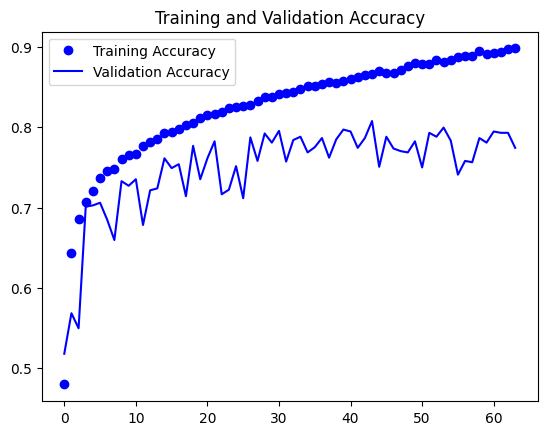

In [101]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

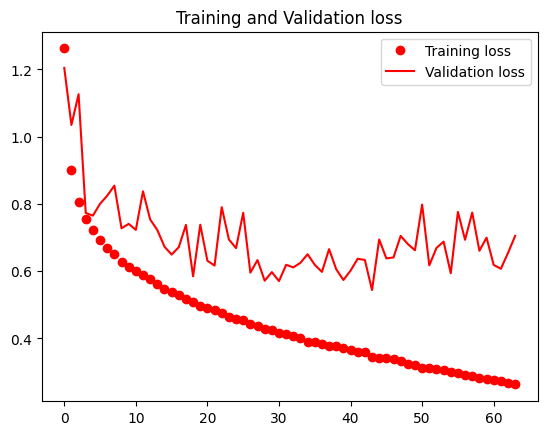

In [102]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [103]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

39/39 [==============================] - 1s 6ms/step


In [104]:
y_true.shape

(1229,)

<Axes: >

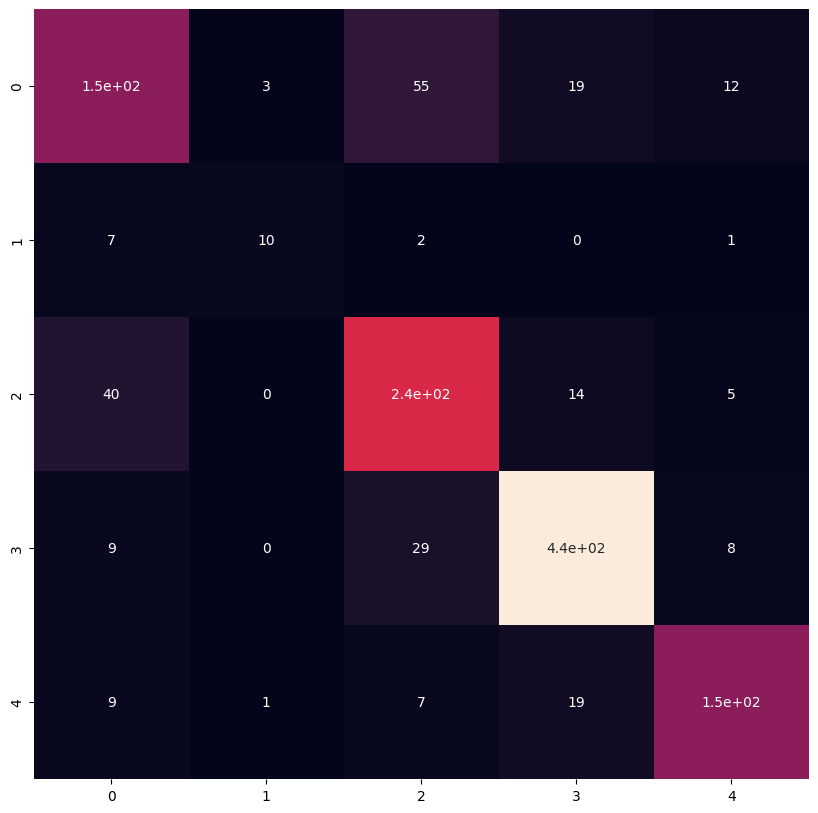

In [105]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

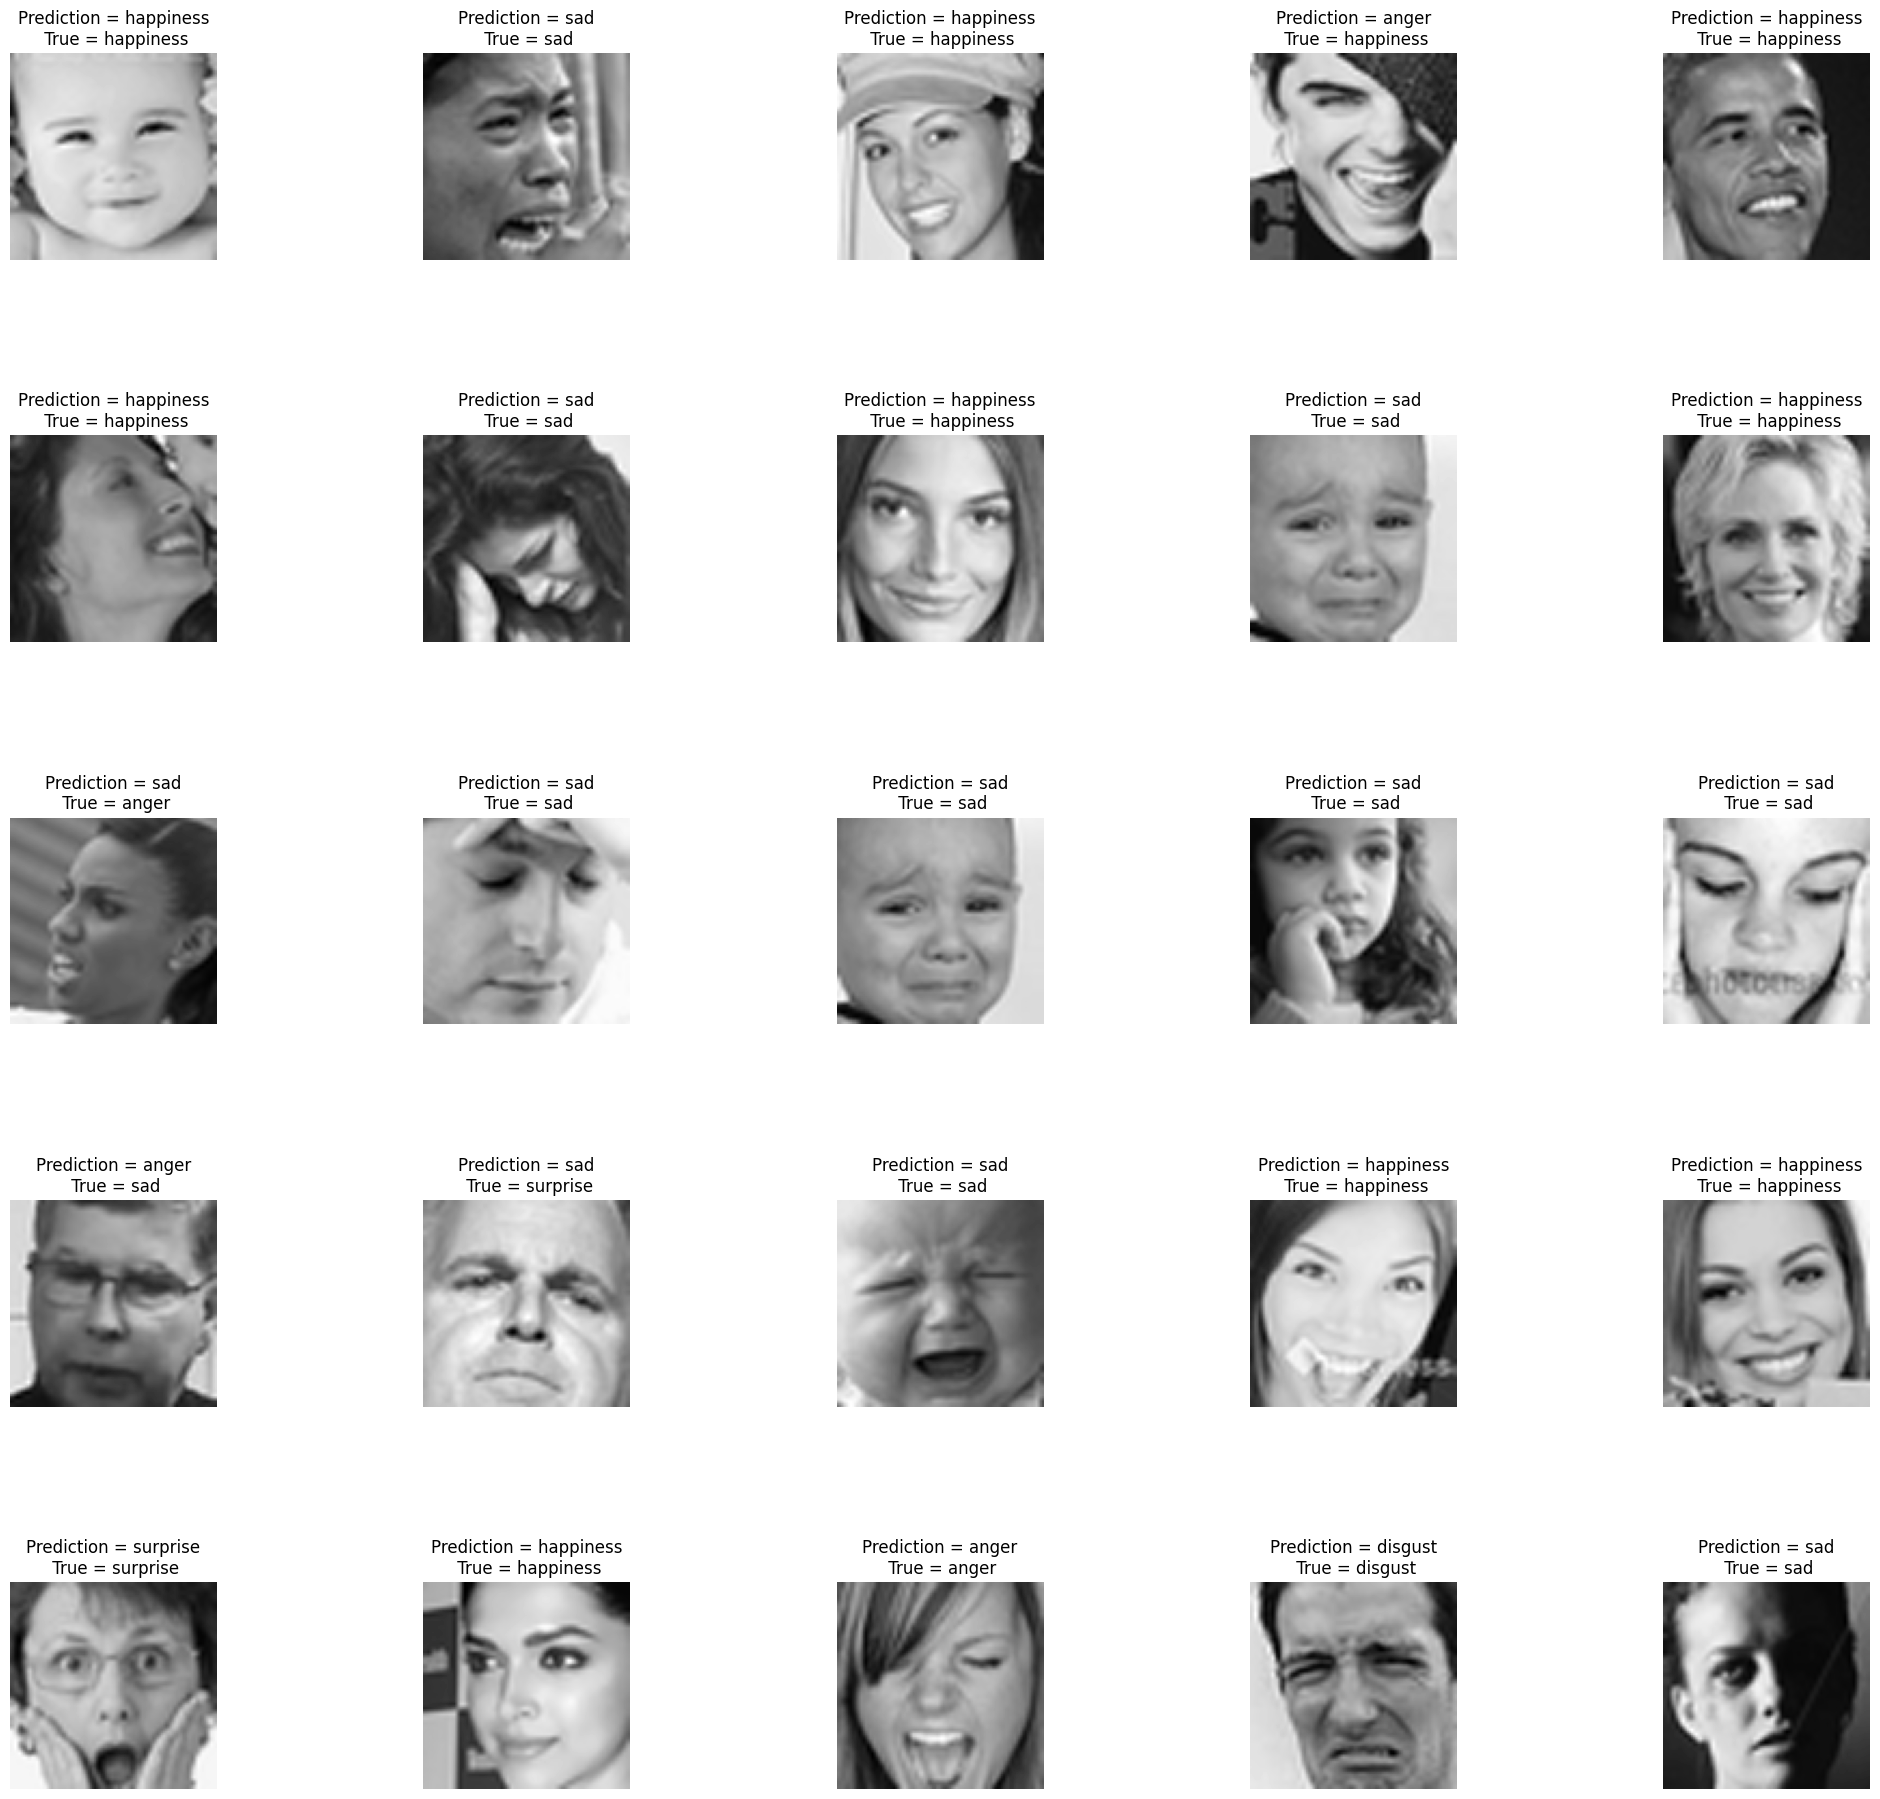

In [106]:
#Printing a grid of 25 images along with their predicted/true label
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_Test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)   

In [107]:
#Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.70      0.63      0.67       243
           1       0.71      0.50      0.59        20
           2       0.72      0.80      0.76       296
           3       0.89      0.90      0.90       482
           4       0.85      0.81      0.83       188

    accuracy                           0.80      1229
   macro avg       0.78      0.73      0.75      1229
weighted avg       0.80      0.80      0.80      1229

